##  APS Failure Prediction on Scania Trucks

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline
import xgboost as xgb
from matplotlib import pyplot
import pickle

In [2]:
df= pd.read_csv('aps_failure_training_set.csv')

In [3]:
df1= pd.read_csv('aps_failure_training_set.csv')

In [4]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [6]:
df.describe()

,aa_000
count,6.000000e+04
mean,5.933650e+04
std,1.454301e+05
min,0.000000e+00
25%,8.340000e+02
50%,3.077600e+04
75%,4.866800e+04
max,2.746564e+06


## Data Cleaning Train Dataset

In [7]:
df['class']= df['class'].replace(['pos','neg'],[1,0])

In [8]:
df=df.replace('na',np.NaN)

In [9]:
df['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

In [10]:
df=df.astype(float)
for i in df:
    if df[i].std() ==0:
        df=df.drop([i],axis=1)

In [11]:
df.shape

(60000, 170)

In [12]:
df=df.drop_duplicates(keep='first')
df=df.T.drop_duplicates().T

In [13]:
df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,153002.0,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,0.0,2286.0,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,112.0,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,0.0,80292.0,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


## Data Cleaning for Test Datasets

In [14]:
df_test= pd.read_csv('aps_failure_test_set.csv')

In [15]:
df_test['class']= df_test['class'].replace(['pos','neg'],[1,0])
df_test=df_test.replace('na',np.NaN)
df_test=df_test.astype(float)

for i in df_test:
    if df_test[i].std() ==0:
        df_test=df_test.drop([i],axis=1)


df_test=df_test.drop_duplicates(keep='first')
df_test=df_test.T.drop_duplicates().T

In [16]:
df_test.shape

(16000, 170)

## Exploratory Data Analysis

In [17]:
missing_values_count= dict(df.drop('class',axis=1).isnull().sum())
missing_values_count= dict(sorted(missing_values_count.items(),key=lambda item:item[1],reverse=True))

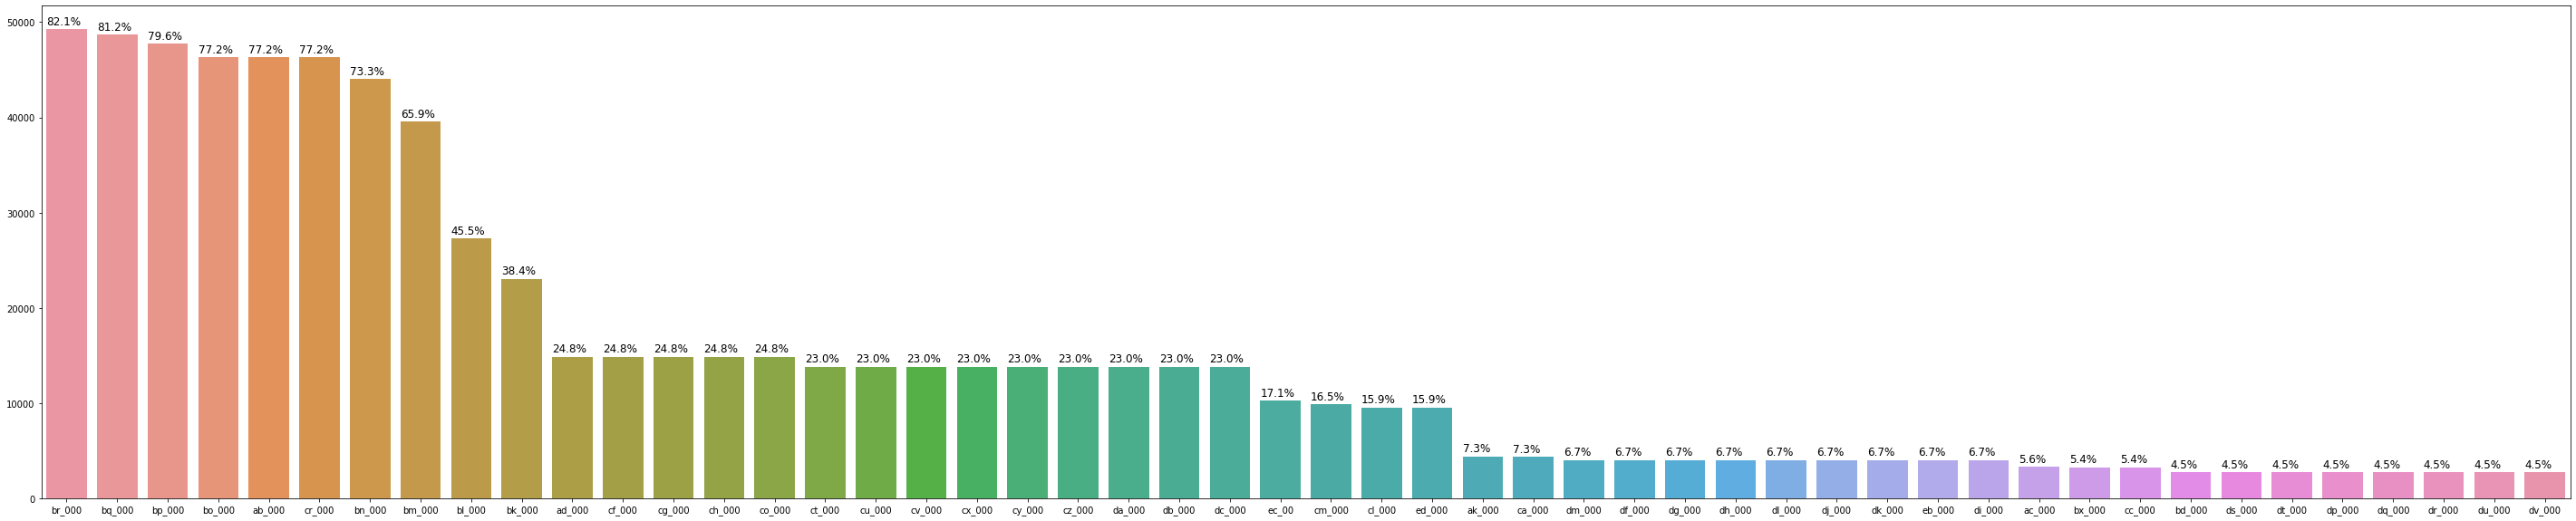

In [18]:
def barplot(data,sum):
    plt.figure(figsize = (50,10))
    ax = sns.barplot(x = list(data.keys())[:50], y = list(data.values())[:50])

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/sum)
        x = p.get_x() 
        y = p.get_height()+500
        ax.annotate(percentage,(x,y),size=12)

        
        
barplot(missing_values_count,df.shape[0])


## Separating Histogram and Non-Histogram features from dataset

In [19]:
hist_col= []
for i in df.columns:
    if i[-1]!='0':
        hist_col.append(i)
hist_col.extend(['ag_000','ay_000','az_000','ba_000','cn_000','cs_000','ee_000'])


hist_features= df[hist_col]
hist_features= hist_features.drop('class',axis=1)
num_features= df.drop(hist_col,axis=1)

In [20]:
print(hist_features.shape)
print(num_features.shape)

(59999, 70)
(59999, 99)


## Important Feature Recognition using Recursive Feature Elimimination

In [21]:
def top_features_rfe(X,y,n):
    estimator= RandomForestClassifier(max_depth=5)
    rfe= RFE(estimator=estimator,n_features_to_select=n,verbose=0)
    rfe.fit(X,y)
    return (rfe.support_)

## Important Histogram Features

In [22]:
hist_features['class']=df['class']
imp_hist_features= hist_features.dropna()
y=imp_hist_features['class']
X= imp_hist_features.drop('class',axis=1)
top_hist_features_rfe = top_features_rfe(X,y,10)
top_hist_features=[];
hist_col= X.columns

for i in range(len(hist_col)):
    if top_hist_features_rfe[i]:
        top_hist_features.append(hist_col[i])
        
print('Top histogram features are :', top_hist_features)
print('Total no. of important features :', len(top_hist_features))



Top histogram features are : ['ag_001', 'ag_002', 'ay_005', 'cn_004', 'cs_002', 'cs_004', 'ee_005', 'ba_000', 'cn_000', 'ee_000']
Total no. of important features : 10


In [23]:
top_hist_features =  ['ag_001', 'ag_002', 'ag_003', 'ay_005', 'ba_004', 'cn_004', 'cs_002', 'ee_005', 'ba_000', 'cn_000']

## Important Numerical Features

In [24]:
num_features['class'] = df['class']
imp_num_features = num_features.dropna()
y = imp_num_features['class']
X = imp_num_features.drop('class',axis=1)
top_num_features_rfe = top_features_rfe(X,y,10) 
top_num_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
    if top_num_features_rfe[i]:
        top_num_features.append(hist_col[i]) 

print("Top numerical features are : ", top_num_features)
print("Total no of important features :", len(top_num_features))

Top numerical features are :  ['ah_000', 'ai_000', 'al_000', 'am_0', 'aq_000', 'bj_000', 'cj_000', 'df_000', 'dn_000', 'dx_000']
Total no of important features : 10


In [25]:
top_num_features = ['ah_000', 'ai_000', 'al_000', 'am_0', 'aq_000', 'bj_000', 'bk_000', 'cj_000', 'df_000', 'dn_000']

In [26]:
hist_features['class'] = df['class']
num_features['class'] = df['class']
print(hist_features.shape)
print(num_features.shape)

(59999, 71)
(59999, 100)


## Univariate Analysis on top 10 histogram features

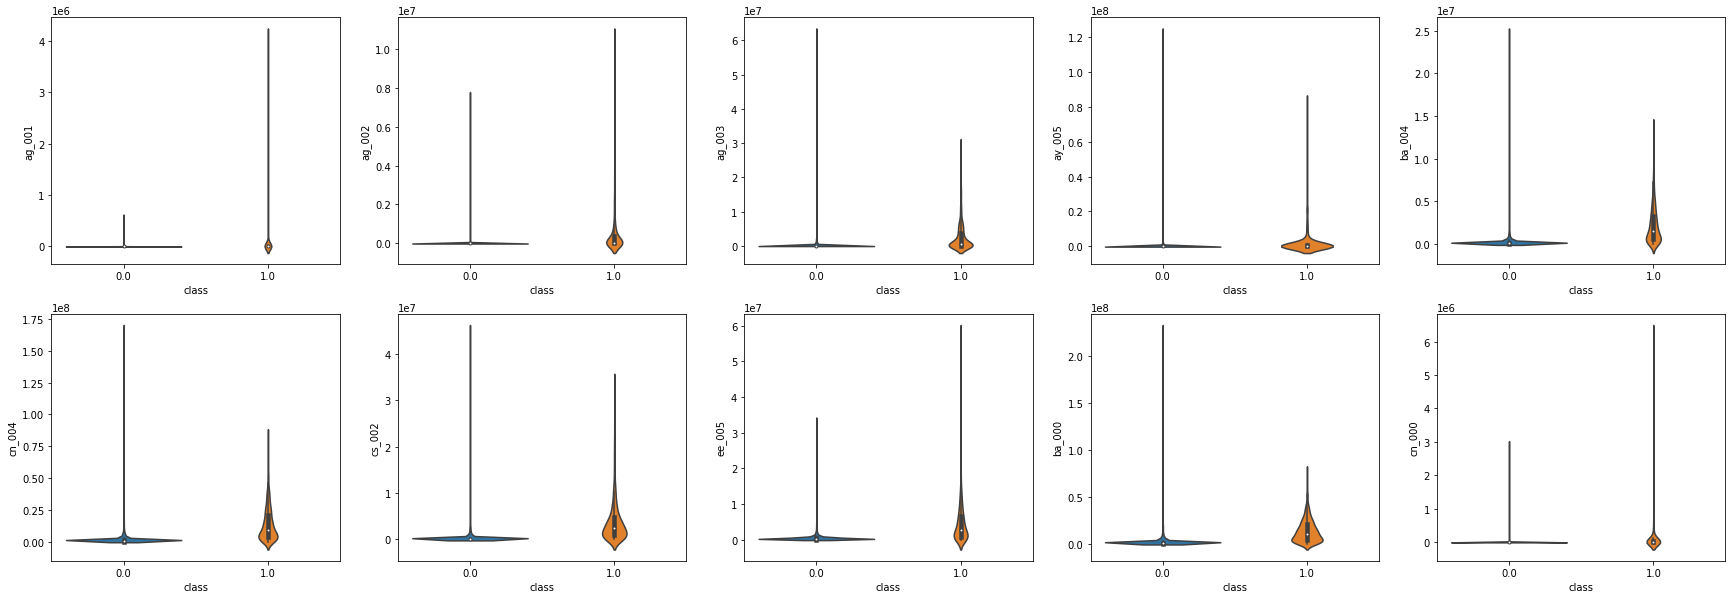

In [27]:
def violin(df,features,row,col):
    k=0
    fig,axes= plt.subplots(row,col,figsize=(30,10))
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            sns.violinplot(x=df['class'],y=features[k],ax=axes[i][j],data=df,size=5)
            if k!= len(features)-1:
                k+=1
            else:
                break
violin(hist_features,top_hist_features,2,5)

In [28]:
f =['ba_004','cn_004','cs_002','ee_005','ba_000']

for i in f:
    print('\nFeature',i)
    print("Class 0 : 90th percentile : ", np.nanpercentile(hist_features[hist_features['class']==0][i],90))
    print("Class 1 : 25th percentile : ", np.nanpercentile(hist_features[hist_features['class']==1][i],25))


Feature ba_004
Class 0 : 90th percentile :  361734.0
Class 1 : 25th percentile :  588036.5

Feature cn_004
Class 0 : 90th percentile :  2281392.0
Class 1 : 25th percentile :  3690910.0

Feature cs_002
Class 0 : 90th percentile :  256878.40000000075
Class 1 : 25th percentile :  864141.0

Feature ee_005
Class 0 : 90th percentile :  708216.0000000001
Class 1 : 25th percentile :  847208.0

Feature ba_000
Class 0 : 90th percentile :  2430826.3999999994
Class 1 : 25th percentile :  4299871.0


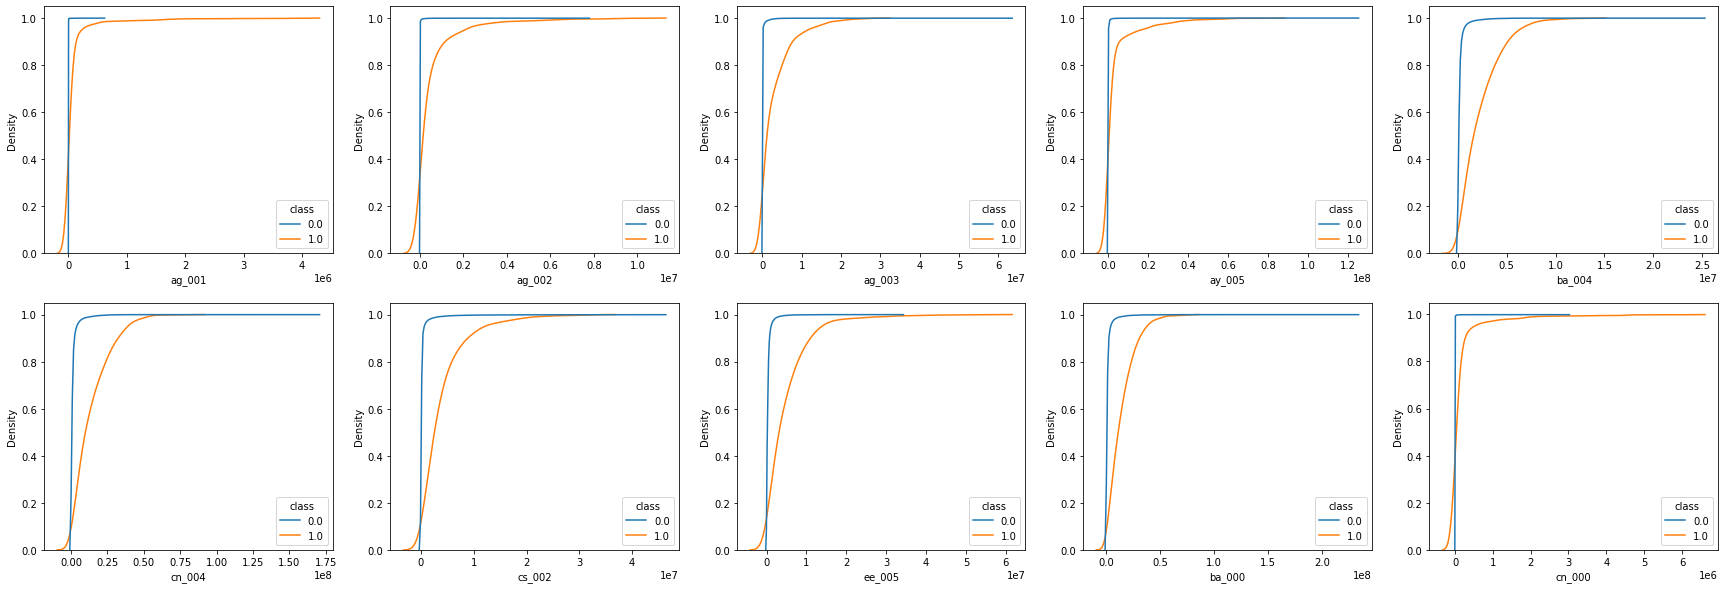

In [29]:

def cdf(df,features,row,col):
    k=0
    fig,axes = plt.subplots(row,col,figsize=(30,10))
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            sns.kdeplot(x=df[features[k]], data=df, hue='class', cumulative=True, common_norm=False, ax = axes[i][j])
            if k!= len(features)-1:
                k+=1
            else:
                break
cdf(hist_features,top_hist_features,2,5)

## Bivariate Analysis on top 5 histogram features

In [30]:
hist_features['class'] = df['class']
imp_hist_features = hist_features.dropna()
y = imp_hist_features['class']
X = imp_hist_features.drop('class',axis=1)
top_hist_features_rfe = top_features_rfe(X,y,5) 
top_hist_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
    if top_hist_features_rfe[i]:
        top_hist_features.append(hist_col[i]) 


print("Top histogram features are : ", top_hist_features)
print("Total no of important features :", len(top_hist_features))

Top histogram features are :  ['ag_002', 'ay_005', 'cs_002', 'ee_005', 'ba_000']
Total no of important features : 5


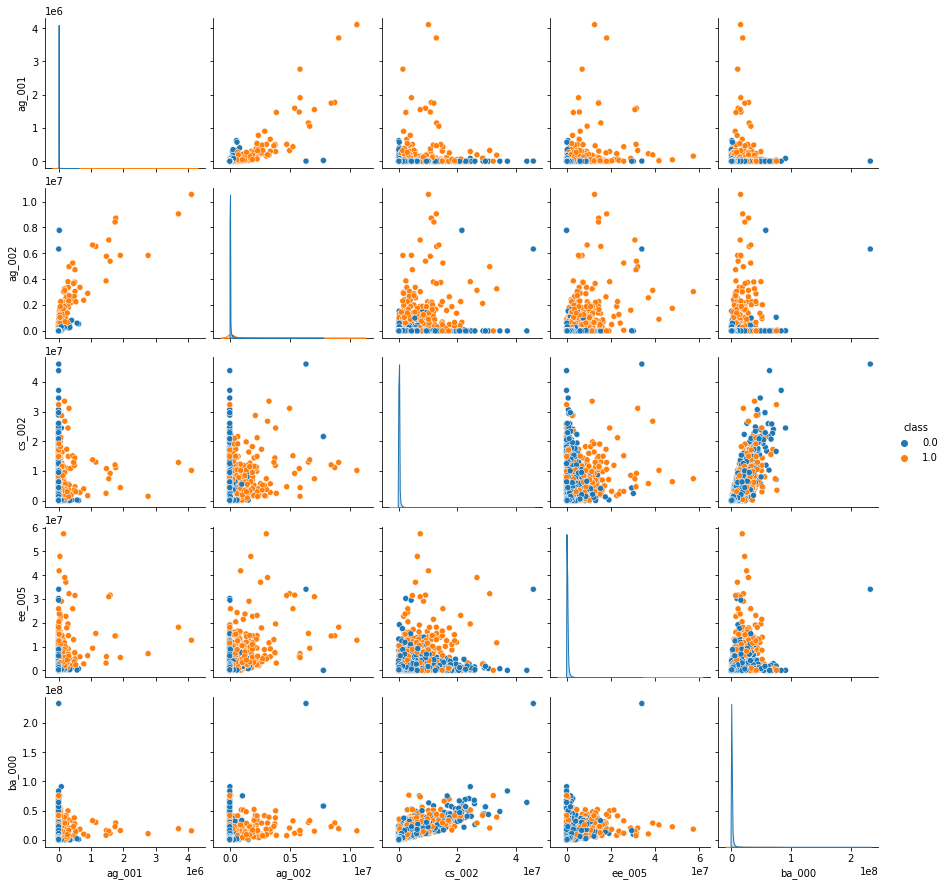

In [31]:
a = [ 'ag_001', 'ag_002', 'cs_002', 'ee_005', 'ba_000' , 'class']
pairplot_features = hist_features[a]
sns.pairplot(pairplot_features, hue = 'class')

## Univariate Analysis on Numerical Features 

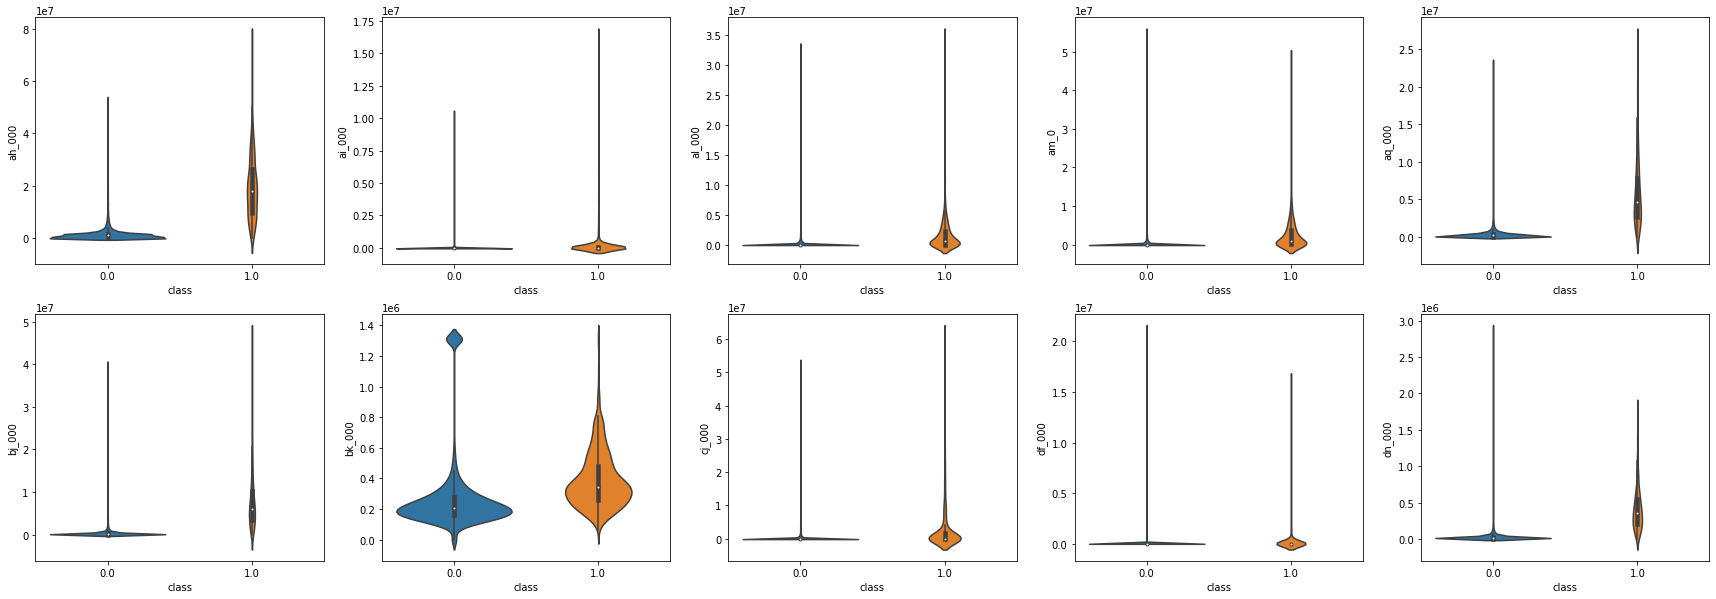

In [32]:
violin(num_features,top_num_features,2,5)

In [33]:
f = [ 'ah_000' , 'aq_000' , 'bj_000' , 'dn_000' ]
for i in f:
    print("\nFeature ", i)
    print("Class 0 : 90th percentile : ", np.nanpercentile(num_features[num_features['class']==0][i],90))
    print("Class 1 : 10th percentile : ", np.nanpercentile(num_features[num_features['class']==1][i],10))



Feature  ah_000
Class 0 : 90th percentile :  3036369.9999999995
Class 1 : 10th percentile :  5105593.600000002

Feature  aq_000
Class 0 : 90th percentile :  728333.2
Class 1 : 10th percentile :  1213968.4000000001

Feature  bj_000
Class 0 : 90th percentile :  695903.1999999998
Class 1 : 10th percentile :  1393952.4000000001

Feature  dn_000
Class 0 : 90th percentile :  52318.2
Class 1 : 10th percentile :  103516.4


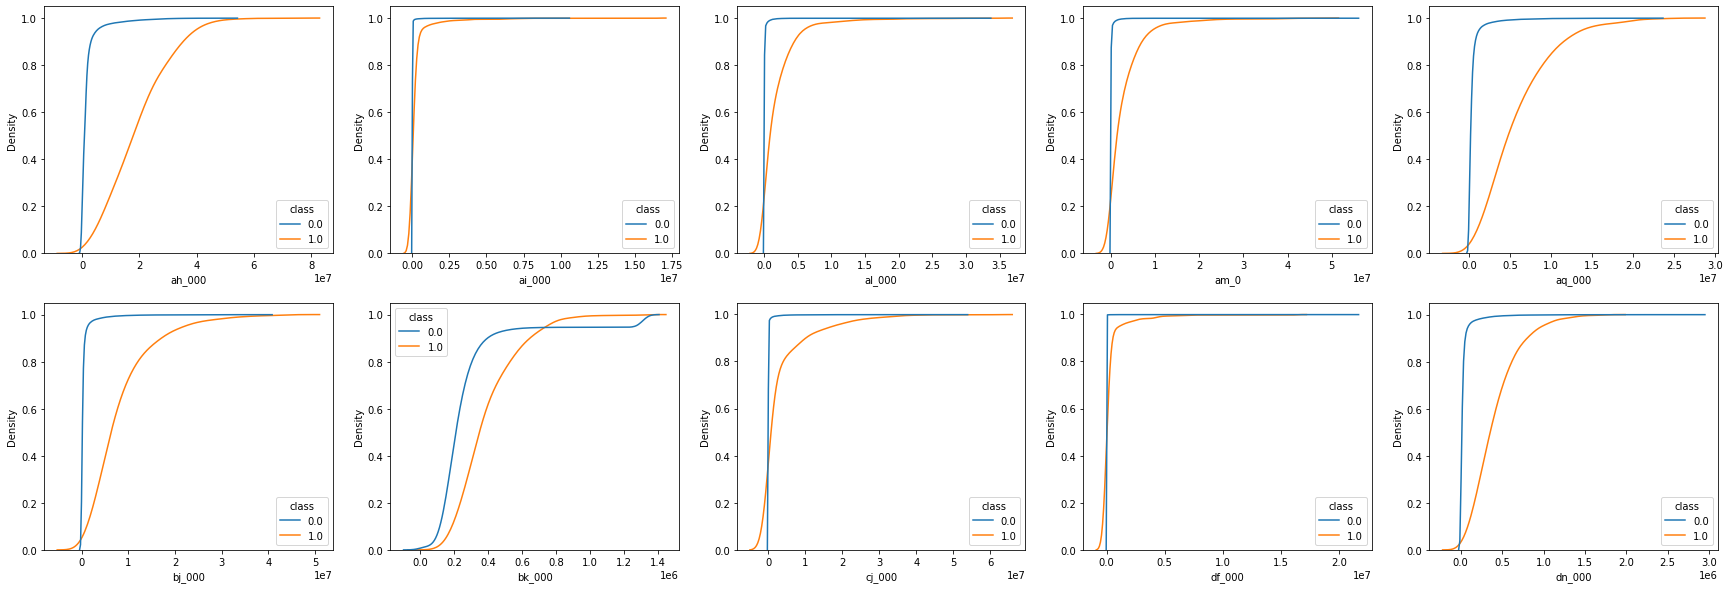

In [34]:
cdf(num_features,top_num_features,2,5)

## Bivariate Analysis on the top 5 numerical features

In [35]:
num_features['class'] = df['class']
imp_num_features = num_features.dropna()
y = imp_num_features['class']
X = imp_num_features.drop('class',axis=1)
top_num_features_rfe = top_features_rfe(X,y,5) 
top_num_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
    if top_num_features_rfe[i]:
        top_num_features.append(hist_col[i]) 

print("Top histogram features are : ", top_num_features)
print("Total no of important features :", len(top_num_features))

Top histogram features are :  ['ai_000', 'al_000', 'am_0', 'aq_000', 'bj_000']
Total no of important features : 5


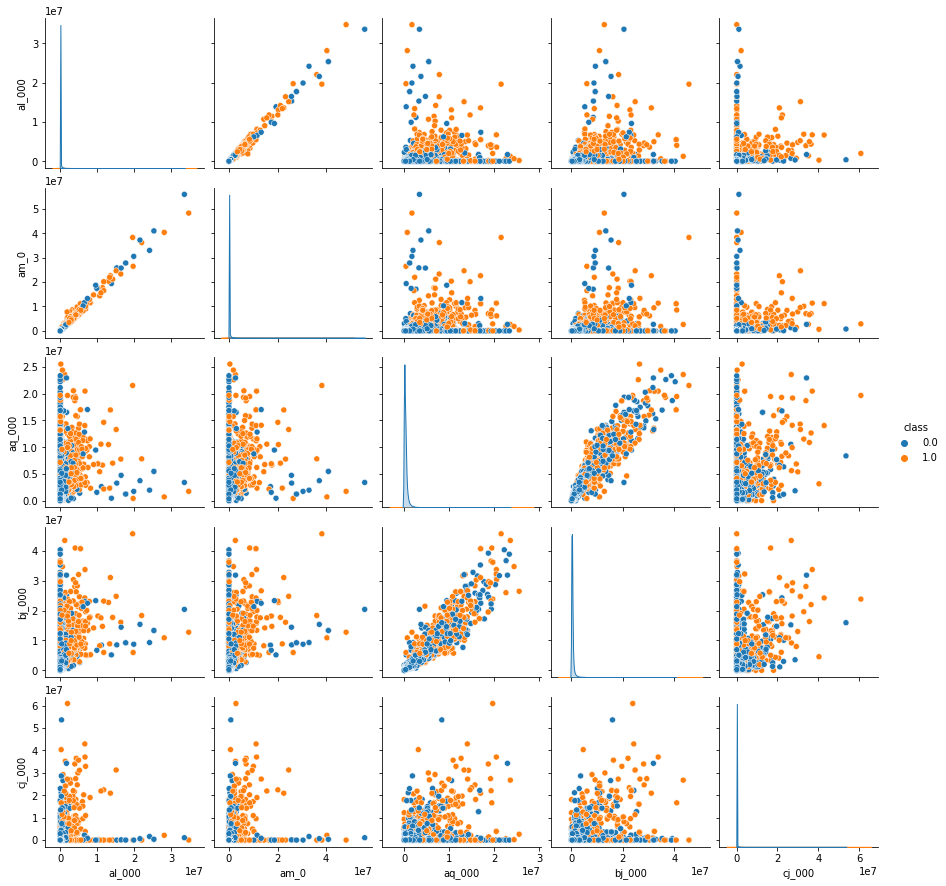

In [36]:
a = ['al_000', 'am_0', 'aq_000', 'bj_000', 'cj_000','class']
sns.pairplot(num_features[a], hue='class')

## Missing Values Imputation

In [37]:
features_tobe_eliminated = []
median_imp_features = []
model_imp_features = []
for i in missing_values_count.keys():
    percent = (missing_values_count[i]/df.shape[0])
    if percent > 0.6:
        features_tobe_eliminated.append(i)
    elif percent < 0.2:
        median_imp_features.append(i)
    else:
        model_imp_features.append(i)

print("Number of features to be eliminated : ",len(features_tobe_eliminated))
print("Number of features for model imputation : ",len(model_imp_features))
print("Number of features for median imputaton : ",len(median_imp_features))

Number of features to be eliminated :  8
Number of features for model imputation :  16
Number of features for median imputaton :  145


## Train,Test,Split Data

In [38]:
X = df.drop('class',axis=1)
y = df['class']
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_test = df_test.drop('class',axis=1)
y_test = df_test['class']

X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_cv.reset_index(drop=True,inplace=True)
y_cv.reset_index(drop=True,inplace=True)

## Median Imputation on features with less than 20% missing values

In [39]:
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train[median_imp_features])

X_train_median = median_imputer.transform(X_train[median_imp_features])
X_cv_median = median_imputer.transform(X_cv[median_imp_features])
X_test_median = median_imputer.transform(X_test[median_imp_features])

## Model Based Imputation on features greater than 20% missing values

In [40]:
X_train_mice = X_train.copy()
X_train_mice[median_imp_features] = X_train_median
X_train_mice = X_train_mice.drop(features_tobe_eliminated,axis=1)
print(X_train_mice.shape)

X_cv_mice = X_cv.copy()
X_cv_mice[median_imp_features] = X_cv_median
X_cv_mice = X_cv_mice.drop(features_tobe_eliminated,axis=1)
print(X_cv_mice.shape)

X_test_mice = X_test.copy()
X_test_mice[median_imp_features] = X_test_median
X_test_mice = X_test_mice.drop(features_tobe_eliminated,axis=1)
print(X_test_mice.shape)
     

(41999, 161)
(18000, 161)
(16000, 161)


## Normalizing the dataset before MICE imputation

In [41]:
def normalize(df):
    x = df.values 
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return x_scaled, min_max_scaler

In [42]:
X_train_scaled, scaler = normalize(X_train_mice)
X_cv_scaled = scaler.transform(X_cv_mice)
X_test_scaled = scaler.transform(X_test_mice)

X_train_mice = pd.DataFrame(X_train_scaled, columns= X_train_mice.columns)
X_cv_mice = pd.DataFrame(X_cv_scaled, columns= X_cv_mice.columns)
X_test_mice = pd.DataFrame(X_test_scaled, columns= X_test_mice.columns)
     

C:\Users\venka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\venka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


## MICE Imputation

In [43]:
def mice_imputation(df):
    mice_imputer = IterativeImputer(random_state=42)
    df_imputed = mice_imputer.fit_transform(df)
  
    return df_imputed, mice_imputer

In [44]:
X_train_imputed, mice_imputer = mice_imputation(X_train_mice)
X_cv_imputed = mice_imputer.transform(X_cv_mice)
X_test_imputed = mice_imputer.transform(X_test_mice)

X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_mice.columns)
X_cv_imputed = pd.DataFrame(X_cv_imputed, columns=X_cv_mice.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_mice.columns)

C:\Users\venka\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Storing the Imputed Dataset as csv file and imputer models as pickle file

In [ ]:
X_train_imputed['class']=y_train
X_cv_imputed['class']=y_cv
X_test_imputed['class']=y_test

X_train_imputed.to_csv('train_scania_imputed.csv',index=False)
X_train_imputed.to_csv('cv_scania_imputed.csv',index=False)
X_train_imputed.to_csv('test_scania_imputed.csv',index=False)


pickle.dump(median_imputer,open('median_imputer.pkl','wb'))
pickle.dump(scaler,open('scaler.pkl','wb'))
pickle.dump(median_imputer,open('MICE_imputer.pkl','wb'))

### Load the MICE Imputed Dataset

In [46]:
train_MICE_imputed= pd.read_csv('train_scania_imputed.csv')
cv_MICE_imputed= pd.read_csv('cv_scania_imputed.csv')
test_MICE_imputed= pd.read_csv('test_scania_imputed.csv')

## Feature Engineering

In [48]:
X_train_tf= train_MICE_imputed.drop('class',axis=1)
X_cv_tf= cv_MICE_imputed.drop('class',axis=1)
n_inputs= X_train_tf.shape[1]

Epoch 1/50
2625/2625 - 7s - loss: 0.0038 - val_loss: 7.0706e-04 - 7s/epoch - 3ms/step
Epoch 2/50
2625/2625 - 7s - loss: 7.5856e-04 - val_loss: 6.6595e-04 - 7s/epoch - 3ms/step
Epoch 3/50
2625/2625 - 7s - loss: 6.3471e-04 - val_loss: 7.7132e-04 - 7s/epoch - 3ms/step
Epoch 4/50
2625/2625 - 8s - loss: 5.4487e-04 - val_loss: 5.5418e-04 - 8s/epoch - 3ms/step
Epoch 5/50
2625/2625 - 8s - loss: 4.6954e-04 - val_loss: 6.0427e-04 - 8s/epoch - 3ms/step
Epoch 6/50
2625/2625 - 8s - loss: 4.0694e-04 - val_loss: 3.9457e-04 - 8s/epoch - 3ms/step
Epoch 7/50
2625/2625 - 8s - loss: 3.7584e-04 - val_loss: 3.0223e-04 - 8s/epoch - 3ms/step
Epoch 8/50
2625/2625 - 8s - loss: 3.4462e-04 - val_loss: 3.3057e-04 - 8s/epoch - 3ms/step
Epoch 9/50
2625/2625 - 7s - loss: 3.1939e-04 - val_loss: 2.3910e-04 - 7s/epoch - 3ms/step
Epoch 10/50
2625/2625 - 7s - loss: 2.9478e-04 - val_loss: 1.9303e-04 - 7s/epoch - 2ms/step
Epoch 11/50
2625/2625 - 7s - loss: 2.7632e-04 - val_loss: 2.1719e-04 - 7s/epoch - 2ms/step
Epoch 12/50


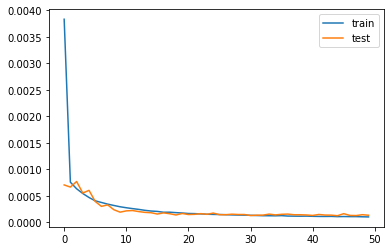

In [50]:
visible= Input(shape=(n_inputs,))

e= Dense(n_inputs*2)(visible)
e= BatchNormalization()(e)
e=LeakyReLU()(e)
e=Dense(n_inputs)(e)
e=BatchNormalization()(e)
e=LeakyReLU()(e)


n_bottleneck= 50
bottleneck= Dense(n_bottleneck)(e)

d= Dense(n_inputs)(bottleneck)
d=BatchNormalization()(d)
d=LeakyReLU()(d)
d=Dense(n_inputs*2)(d)
d=BatchNormalization()(d)
d=LeakyReLU()(d)


output=Dense(n_inputs,activation='linear')(d)
model= Model(inputs=visible,outputs=output)

model.compile(optimizer='adam',loss='mse')

history = model.fit(X_train_tf, X_train_tf, epochs=50, batch_size=16, verbose=2, validation_data=(X_cv_tf,X_cv_tf))
pyplot.plot(history.history['loss'],label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()

In [51]:
encoder= Model(inputs=visible,  outputs=bottleneck)
encoder.save('mice_encoder.h5')

In [52]:
from tensorflow.keras.models import load_model
encoder=load_model('mice_encoder.h5')

In [53]:
print('Train Data')
X_train_encode = encoder.predict(train_MICE_imputed.drop('class',axis=1))
print(X_train_encode.shape)
X_train_mice_final = np.hstack((np.array(train_MICE_imputed.drop('class',axis=1)),X_train_encode))
print(X_train_mice_final.shape)
y_train_mice_final = train_MICE_imputed['class']
print(y_train_mice_final.shape)


print('CV Data')
X_cv_encode = encoder.predict(cv_MICE_imputed.drop('class',axis=1))
print(X_cv_encode.shape)
X_cv_mice_final = np.hstack((np.array(cv_MICE_imputed.drop('class',axis=1)),X_cv_encode))
print(X_cv_mice_final.shape)
y_cv_mice_final = cv_MICE_imputed['class']
print(y_cv_mice_final.shape)


print('Test Data')
X_test_encode = encoder.predict(test_MICE_imputed.drop('class',axis=1))
print(X_test_encode.shape)
X_test_mice_final = np.hstack((np.array(test_MICE_imputed.drop('class',axis=1)),X_test_encode))
print(X_test_mice_final.shape)
y_test_mice_final = test_MICE_imputed['class']
print(y_test_mice_final.shape)

Train Data
1313/1313 [==============================] - 1s 753us/step
(41999, 50)
(41999, 211)
(41999,)
CV Data
1313/1313 [==============================] - 1s 744us/step
(41999, 50)
(41999, 211)
(41999,)
Test Data
1313/1313 [==============================] - 1s 816us/step
(41999, 50)
(41999, 211)
(41999,)


In [56]:
over=SMOTE(sampling_strategy=0.5,random_state=42)
under= RandomUnderSampler(sampling_strategy=0.6)
steps= [('o',over),('u',under)]
pipeline= Pipeline(steps=steps)

X_train_mice_final,y_train_mice_final= pipeline.fit_resample(X_train_mice_final,y_train_mice_final)

In [57]:
pd.DataFrame(y_train_mice_final).value_counts()

class
0.0      34415
1.0      20649
dtype: int64

In [58]:
print('Dataset after balancing using SMOTE ')
print('Train Data')
print(X_train_mice_final.shape)
print(y_train_mice_final.shape)
print('CV Data')
print(X_cv_mice_final.shape)
print(y_cv_mice_final.shape)
print('Test Data')
print(X_test_mice_final.shape)
print(y_test_mice_final.shape)

Dataset after balancing using SMOTE 
Train Data
(55064, 211)
(55064,)
CV Data
(41999, 211)
(41999,)
Test Data
(41999, 211)
(41999,)


In [59]:
pickle.dump((X_train_mice_final,y_train_mice_final),open('mice_train_data.pkl','wb'))
pickle.dump((X_cv_mice_final,y_cv_mice_final),open('mice_cv_data.pkl','wb'))
pickle.dump((X_test_mice_final,y_test_mice_final),open('mice_test_data.pkl','wb'))

In [60]:
X_train_final,y_train_final= pickle.load(open('mice_train_data.pkl','rb'))
X_cv_final, y_cv_final= pickle.load(open('mice_cv_data.pkl','rb'))
X_test,y_test=pickle.load(open('mice_test_data.pkl','rb'))

In [61]:
print('Train Data')
print(X_train.shape)
print(y_train.shape)
print('CV Data')
print(X_cv.shape)
print(y_cv.shape)
print('Test Data')
print(X_test.shape)
print(y_test.shape)     

Train Data
(41999, 169)
(41999,)
CV Data
(18000, 169)
(18000,)
Test Data
(41999, 211)
(41999,)


### Plotting Functions

In [62]:
def cm_heatmap(cm):
    A= (((cm.T)/(cm.sum(axis=1))).T)
    B= (cm/cm.sum(axis=0))
    labels= [0,1]
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1);
    sns.heatmap(cm,annot=True,fmt='.3f',cmap='Blues',xticklabels=labels,yticklabels=labels)
    
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels');
    plt.title('Confusion Matrix');
    
    
    plt.subplot(1,3,2)
    sns.heatmap(B,annot=True,fmt='.3f',cmap='Blues',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels');
    plt.title('Precision Matrix');
    
    plt.subplot(1,3,3)
    sns.heatmap(A,annot=True,fmt='.3f',cmap='Blues',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels');
    plt.title('Recall Matrix');

In [63]:
def cv_plot(results,alpha):
    train_score= results['mean_train_score']
    cv_score= results['mean_test_score']
    
    plt.plot(alpha,train_score,label='Train f1-macro')
    plt.plot(alpha,cv_score,label='CV f1-macro')
    
    plt.scatter(alpha,train_score,label='Train f1-macro')
    plt.scatter(alpha,cv_score,label='CV f1-macro')
    
    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("f1-macro")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()

In [97]:
def best_prob(y_predicted,y_actual,p):
    y_pred=[]
    cost_list=[]
    for i in p:
        for j in y_predicted:
            if j>=i:
                y_pred.append(1)
            else:
                y_pred.append(0)

        cm = confusion_matrix(y_actual,y_pred)
        tn, fp, fn, tp = cm.ravel()
        cost = (10 * fp) + (500 * fn)
        cost_list.append(cost)
        y_pred=[]
    best_cost = min(cost_list)
    best_p = p[cost_list.index(best_cost)]
    return best_p

## Baseline Random Model

Macro average f1-score :  0.4957982184446206
Cost : 350000


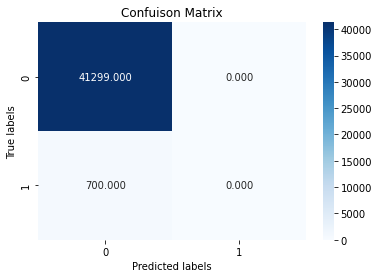

In [67]:
n= y_test.shape[0]
y_test_pred= np.zeros(n)
cm= confusion_matrix(y_test,y_test_pred)
labels=[0,1]
sns.heatmap(cm,annot=True,fmt='.3f',cmap='Blues',xticklabels=labels,yticklabels=labels)

plt.xlabel('Predicted labels');
plt.ylabel('True labels');
plt.title('Confuison Matrix');

f1_scr = f1_score(y_test,y_test_pred,average='macro')
print('Macro average f1-score : ', f1_scr)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp)+ (500*fn)
print('Cost :', cost)

## Logistic Regression Model

{'alpha': 0.001}


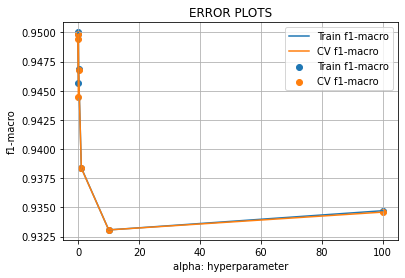

In [72]:
alpha = [0.0001 , 0.001 , 0.01, 0.1 , 1, 10 , 100]
param = {'alpha' : alpha}
clf = SGDClassifier(loss='log', n_jobs=-1, random_state = 42, class_weight='balanced')
tuning = GridSearchCV(estimator=clf,param_grid=param,cv=5,scoring='f1_macro',n_jobs=-1,return_train_score=True)
tuning.fit(X_train_final,y_train_final)
best = tuning.best_params_
print(best)
cv_plot(tuning.cv_results_,alpha)

In [77]:
best_LR_model = SGDClassifier(alpha=0.001,loss='log' , n_jobs = -1, random_state=42, class_weight= 'balanced')
calib_LR = CalibratedClassifierCV(base_estimator=best_LR_model, cv=10, method='sigmoid')
calib_LR.fit(X_train_final,y_train_final)

y_pred = calib_LR.predict(X_train_final)
f1_scr = f1_score(y_train_final,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_LR.predict(X_cv_final)
f1_scr = f1_score(y_cv_final,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_LR.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9434700961537135
Macro average f1-score on CV Data :  0.7705404044048493
Macro average f1-score on Test Data :  0.7705404044048493


In [88]:
y_train_pred = calib_LR.predict_proba(X_train_final)[:,1] 
y_cv_pred = calib_LR.predict_proba(X_cv_final)[:,1]
y_test_pred = calib_LR.predict_proba(X_test)[:,1]

Best probability Threshold is :  0.2646660160503361
Train Cost :  446530
CV Cost :  36000
Test Cost :  36000


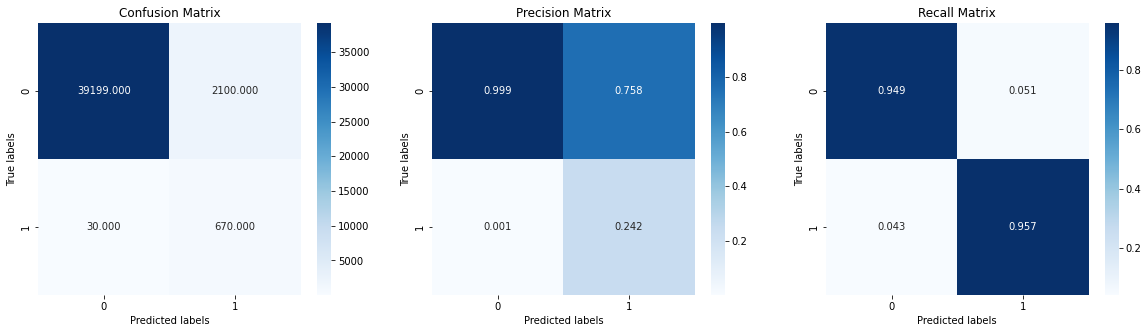

In [98]:
precision, recall, thresholds = precision_recall_curve(y_cv_final, y_cv_pred)
p = best_prob(y_cv_pred,y_cv_final,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)

cm = confusion_matrix(y_train_final,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Train Cost : ", cost)

y_pred=[]
for i in y_cv_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)

cm = confusion_matrix(y_cv_final,y_pred)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("CV Cost : ", cost)

y_pred=[]
for i in y_test_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)

cm = confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn, fp, fn, tp = cm.ravel()
cost = (10 * fp) + (500 * fn)
print("Test Cost : ", cost)

### Linear SVM

{'alpha': 0.01}


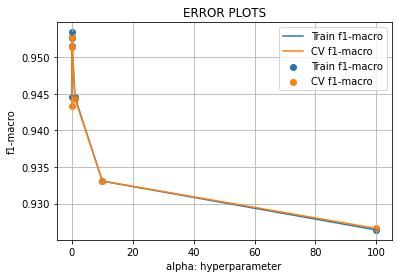

In [101]:
alpha= [0.0001,0.001,0.01,0.1,1,10,100]
param_grid_svm = {'alpha':alpha}
clf_linear_svm = SGDClassifier(loss='hinge',class_weight='balanced',n_jobs=-1,random_state=42)
grid_model_linear_svm = GridSearchCV(estimator=clf_linear_svm,param_grid=param_grid_svm,cv=5,scoring='f1_macro',n_jobs=-1,return_train_score=True)
grid_model_linear_svm.fit(X_train_final,y_train_final)
grid_model_linear_svm.fit(X_train_final,y_train_final)
best_params= grid_model_linear_svm.best_params_
print(best_params)
cv_plot(grid_model_linear_svm.cv_results_,alpha);

In [103]:
best_SVM_model = SGDClassifier(alpha=0.001,loss= 'hinge',class_weight='balanced',n_jobs=-1,random_state=42)
calib_SVM = CalibratedClassifierCV(base_estimator=best_SVM_model,cv=5,method='sigmoid')
calib_SVM.fit(X_train_final,y_train_final)

y_pred= calib_SVM.predict(X_train_final)
f1_scr= f1_score(y_train_final,y_pred,average='macro')
print('Macro Average f1-score on Train Data : ', f1_scr)


y_pred= calib_SVM.predict(X_cv_final)
f1_scr= f1_score(y_cv_final,y_pred,average='macro')
print('Macro average f1-scoreon CV Data :', f1_scr)


y_pred= calib_SVM.predict(X_test)
f1_scr= f1_score(y_test,y_pred,average='macro')
print('Macro Average f1-score on Test Data : ',f1_scr)

Macro Average f1-score on Train Data :  0.9302508793741344
Macro average f1-scoreon CV Data : 0.791796913597849
Macro Average f1-score on Test Data :  0.791796913597849


Best Probability Threshold is : 0.23699322959402855
Train Cost : 450500
CV cost : 33390
Test Cost : 33390


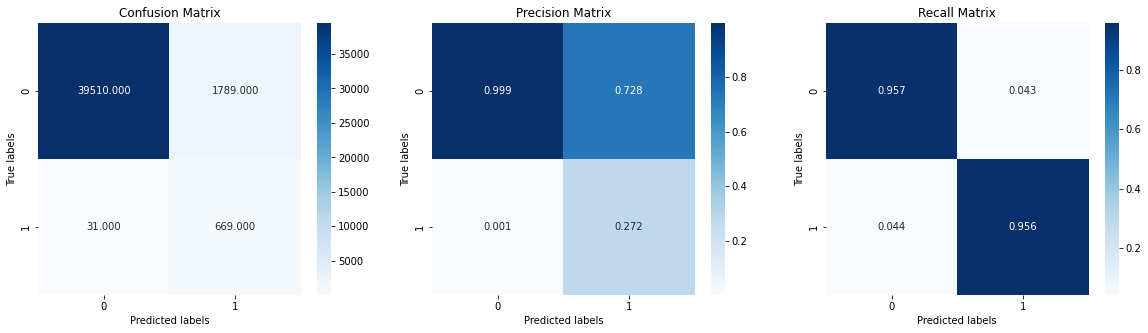

In [107]:
y_train_pred= calib_SVM.predict_proba(X_train_final)[:,1]
y_cv_pred= calib_SVM.predict_proba(X_cv_final)[:,1]
y_test_pred= calib_SVM.predict_proba(X_test)[:,1]

precision,recall,thresholds= precision_recall_curve(y_cv_final,y_cv_pred)
p= best_prob(y_cv_pred,y_cv_final,thresholds)

print('Best Probability Threshold is :', p)

y_pred =[]
for i in y_train_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
cm= confusion_matrix(y_train_final,y_pred)
tn,fp,fn,tp = cm.ravel()
cost= (10*fp) + (500*fn)
print('Train Cost :', cost)

y_pred=[]
for i in y_cv_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)

cm= confusion_matrix(y_cv_final,y_pred)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('CV cost :',cost)


y_pred=[]
for i in y_test_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
cm= confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('Test Cost :', cost)

### Random Forest Model

In [110]:
max_depth= [5,10,20,50]
n_estimators= [10,25,50,80,100]
min_samples_split= [2,5,10,50]

param_grid_rand = {'max_depth':max_depth,'n_estimators':n_estimators,'min_samples_split':min_samples_split}
clf_rand_model= RandomForestClassifier(class_weight='balanced',random_state=42)
grid_model_rand= RandomizedSearchCV(estimator=clf_rand_model,param_distributions=param_grid_rand,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
grid_model_rand.fit(X_train_final,y_train_final)
best_params= grid_model_rand.best_params_
print(best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 25, 'min_samples_split': 2, 'max_depth': 50}


In [111]:
best_RF_model = RandomForestClassifier(max_depth = 50, n_estimators =25 ,min_samples_split=2,n_jobs=-1,class_weight = 'balanced' , random_state=42, criterion='gini')
calib_RF = CalibratedClassifierCV(base_estimator=best_RF_model, cv=3, method='sigmoid')
calib_RF.fit(X_train_final,y_train_final)

y_pred = calib_RF.predict(X_train_final)
f1_scr = f1_score(y_train_final,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_RF.predict(X_cv_final)
f1_scr = f1_score(y_cv_final,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_RF.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9998450198064428
Macro average f1-score on CV Data :  0.985142023401365
Macro average f1-score on Test Data :  0.985142023401365


Best probability Threshold is :  0.45522968526500346
Train Cost : 1520
CV cost : 420
Test Cost : 420


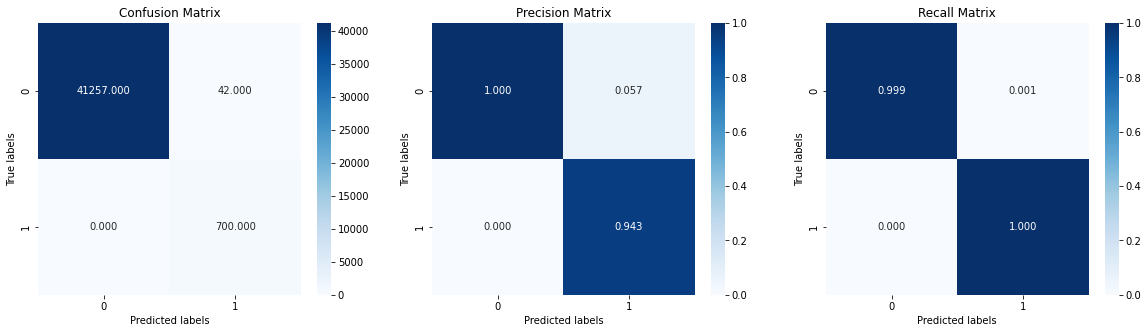

In [113]:
y_train_pred = calib_RF.predict_proba(X_train_final)[:,1]
y_cv_pred = calib_RF.predict_proba(X_cv_final)[:,1]
y_test_pred = calib_RF.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv_final, y_cv_pred)
p = best_prob(y_cv_pred,y_cv_final,thresholds)

print("Best probability Threshold is : ", p)

y_pred =[]
for i in y_train_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
cm= confusion_matrix(y_train_final,y_pred)
tn,fp,fn,tp = cm.ravel()
cost= (10*fp) + (500*fn)
print('Train Cost :', cost)

y_pred=[]
for i in y_cv_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)

cm= confusion_matrix(y_cv_final,y_pred)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('CV cost :',cost)


y_pred=[]
for i in y_test_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
cm= confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('Test Cost :', cost)

### XGBoost Model

In [116]:
max_depth = [5,10,20, 30, 50]
n_estimators = [10,30,50,80,100,250]
colsample_bytree = [0.3,0.5,0.7,1]
subsample = [0.5,0.5,0.7,1]

param_grid_xgboost = {'max_depth':max_depth,'n_estimators':n_estimators, 'colsample_bytree':colsample_bytree,'subsample':subsample}
clf_xgboost = xgb.XGBClassifier(n_jobs=-1, random_state=42, scale_pos_weight = 1.7 )
grid_model_xgboost = RandomizedSearchCV(estimator=clf_xgboost,param_distributions=param_grid_xgboost,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
grid_model_xgboost.fit(X_train_final,y_train_final)
best_params = grid_model_xgboost.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'alpha': 0.001}


In [117]:
print(grid_model_xgboost.best_params_)

{'subsample': 0.5, 'n_estimators': 80, 'max_depth': 30, 'colsample_bytree': 0.5}


In [118]:
best_XGB_model = xgb.XGBClassifier(max_depth = 30, n_estimators =80 , n_jobs=-1, random_state=42, scale_pos_weight = 1.7, subsample=0.5,colsample_bytree=0.5)
calib_XGB = CalibratedClassifierCV(base_estimator=best_XGB_model, cv=5, method='sigmoid')
calib_XGB.fit(X_train_final,y_train_final)

y_pred= calib_SVM.predict(X_train_final)
f1_scr= f1_score(y_train_final,y_pred,average='macro')
print('Macro Average f1-score on Train Data : ', f1_scr)


y_pred= calib_SVM.predict(X_cv_final)
f1_scr= f1_score(y_cv_final,y_pred,average='macro')
print('Macro average f1-scoreon CV Data :', f1_scr)


y_pred= calib_SVM.predict(X_test)
f1_scr= f1_score(y_test,y_pred,average='macro')
print('Macro Average f1-score on Test Data : ',f1_scr)

Macro Average f1-score on Train Data :  0.9302508793741344
Macro average f1-scoreon CV Data : 0.791796913597849
Macro Average f1-score on Test Data :  0.791796913597849


Best probability Threshold is :  0.5275667037814855
Train Cost : 0
CV cost : 290
Test Cost : 290


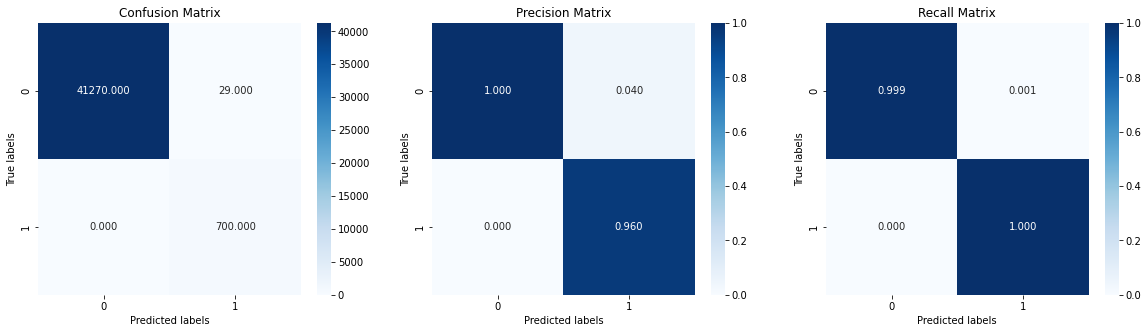

In [120]:
y_train_pred = calib_XGB.predict_proba(X_train_final)[:,1] 
y_cv_pred = calib_XGB.predict_proba(X_cv_final)[:,1]
y_test_pred = calib_XGB.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv_final, y_cv_pred)
p = best_prob(y_cv_pred,y_cv_final,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
  

cm= confusion_matrix(y_train_final,y_pred)
tn,fp,fn,tp = cm.ravel()
cost= (10*fp) + (500*fn)
print('Train Cost :', cost)

y_pred=[]
for i in y_cv_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)

cm= confusion_matrix(y_cv_final,y_pred)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('CV cost :',cost)


y_pred=[]
for i in y_test_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
cm= confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('Test Cost :', cost)

### AdaBoost Classifier

In [125]:
n_estimators = [10,30,50,80,100,250]
learning_rate = [0.001,0.01,0.1,1,10]

DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
LR = LogisticRegression()
base_estimator = [DT,RF,LR]

param_grid_adaboost = {'n_estimators':n_estimators, 'learning_rate':learning_rate,'base_estimator':base_estimator}
clf_ada_boost = AdaBoostClassifier( random_state=42)
grid_model_adaboost = RandomizedSearchCV(estimator=clf_ada_boost,param_distributions=param_grid_adaboost,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True,verbose=10)
grid_model_adaboost.fit(X_train_final,y_train_final)
best_params = grid_model_adaboost.best_params_
print(best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 80, 'learning_rate': 1, 'base_estimator': RandomForestClassifier()}


In [127]:
best_Ada_model = AdaBoostClassifier(n_estimators =80, learning_rate=1, base_estimator=RandomForestClassifier(),random_state=42)
calib_Ada = CalibratedClassifierCV(base_estimator=best_Ada_model, cv=3, method='sigmoid')
calib_Ada.fit(X_train_final,y_train_final)

y_pred = calib_Ada.predict(X_train_final)
f1_scr = f1_score(y_train_final,y_pred, average = 'macro')
print("Macro average f1-score on Train Data : ", f1_scr)

y_pred = calib_Ada.predict(X_cv_final)
f1_scr = f1_score(y_cv_final,y_pred, average = 'macro')
print("Macro average f1-score on CV Data : ", f1_scr)

y_pred = calib_Ada.predict(X_test)
f1_scr = f1_score(y_test,y_pred, average = 'macro')
print("Macro average f1-score on Test Data : ", f1_scr)

Macro average f1-score on Train Data :  0.9998062747580536
Macro average f1-score on CV Data :  0.9823841485237531
Macro average f1-score on Test Data :  0.9823841485237531


Best probability Threshold is :  0.4135832195112406
Train Cost : 1380
CV cost : 1610
Test Cost : 1610


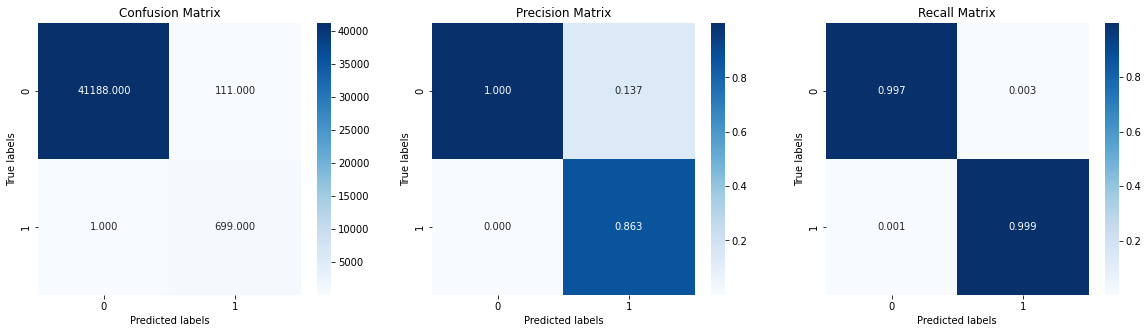

In [129]:
y_train_pred = calib_Ada.predict_proba(X_train_final)[:,1] 
y_cv_pred = calib_Ada.predict_proba(X_cv_final)[:,1]
y_test_pred = calib_Ada.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_cv_final, y_cv_pred)
p = best_prob(y_cv_pred,y_cv_final,thresholds)

print("Best probability Threshold is : ", p)

y_pred=[]
for i in y_train_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
  

cm= confusion_matrix(y_train_final,y_pred)
tn,fp,fn,tp = cm.ravel()
cost= (10*fp) + (500*fn)
print('Train Cost :', cost)

y_pred=[]
for i in y_cv_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)

cm= confusion_matrix(y_cv_final,y_pred)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('CV cost :',cost)


y_pred=[]
for i in y_test_pred:
    if i>=p:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
cm= confusion_matrix(y_test,y_pred)
cm_heatmap(cm)
tn,fp,fn,tp= cm.ravel()
cost= (10*fp) + (500*fn)
print('Test Cost :', cost)

### Summary Of Models

In [131]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = [ 'Model' , 'Probability Threshold' ,'Test Cost']
table.add_row(['Random Model' , '-',350000])
table.add_row(['Logistic Regression Model' , 0.2646, 36000])
table.add_row(['Linear SVM Model' , 0.2369,33390])
table.add_row(['Random Forest Model' , 0.4552,420])
table.add_row(['XGBoost Model' , 0.5275,290])
table.add_row(['AdaBoost Model' , 0.4135,1610])
print(table)

+---------------------------+-----------------------+-----------+
|           Model           | Probability Threshold | Test Cost |
+---------------------------+-----------------------+-----------+
|        Random Model       |           -           |   350000  |
| Logistic Regression Model |         0.2646        |   36000   |
|      Linear SVM Model     |         0.2369        |   33390   |
|    Random Forest Model    |         0.4552        |    420    |
|       XGBoost Model       |         0.5275        |    290    |
|       AdaBoost Model      |         0.4135        |    1610   |
+---------------------------+-----------------------+-----------+


## Therefore XGBoost model is the best model with minimum test cost = 290  